# embedding topology analysis

In [1]:
%load_ext autoreload
%autoreload 2

# Basic setup

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'DejaVu Sans',
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "gut_dev_Huycke"
file_name = "gut_dev_Huycke_Jul17-1902"
file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)
# save_dir = Path(f"../save/{proj_name}-Aug04-0015")

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

seed = 0
ccd.ul.set_seed(seed)

In [4]:
# load the data
adata = sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")

In [5]:
# Define color palette for broad_cell_type
_, _, broad_celltype_pal = ccd.pl.get_color_mapping(adata, 'broad_cell_type', pal='Set1', seed=seed)
_, _, phase_pal = ccd.pl.get_color_mapping(adata, 'phase', pal='Set1', seed=seed)

pal = {"broad_cell_type": broad_celltype_pal,
    'phase': phase_pal,}

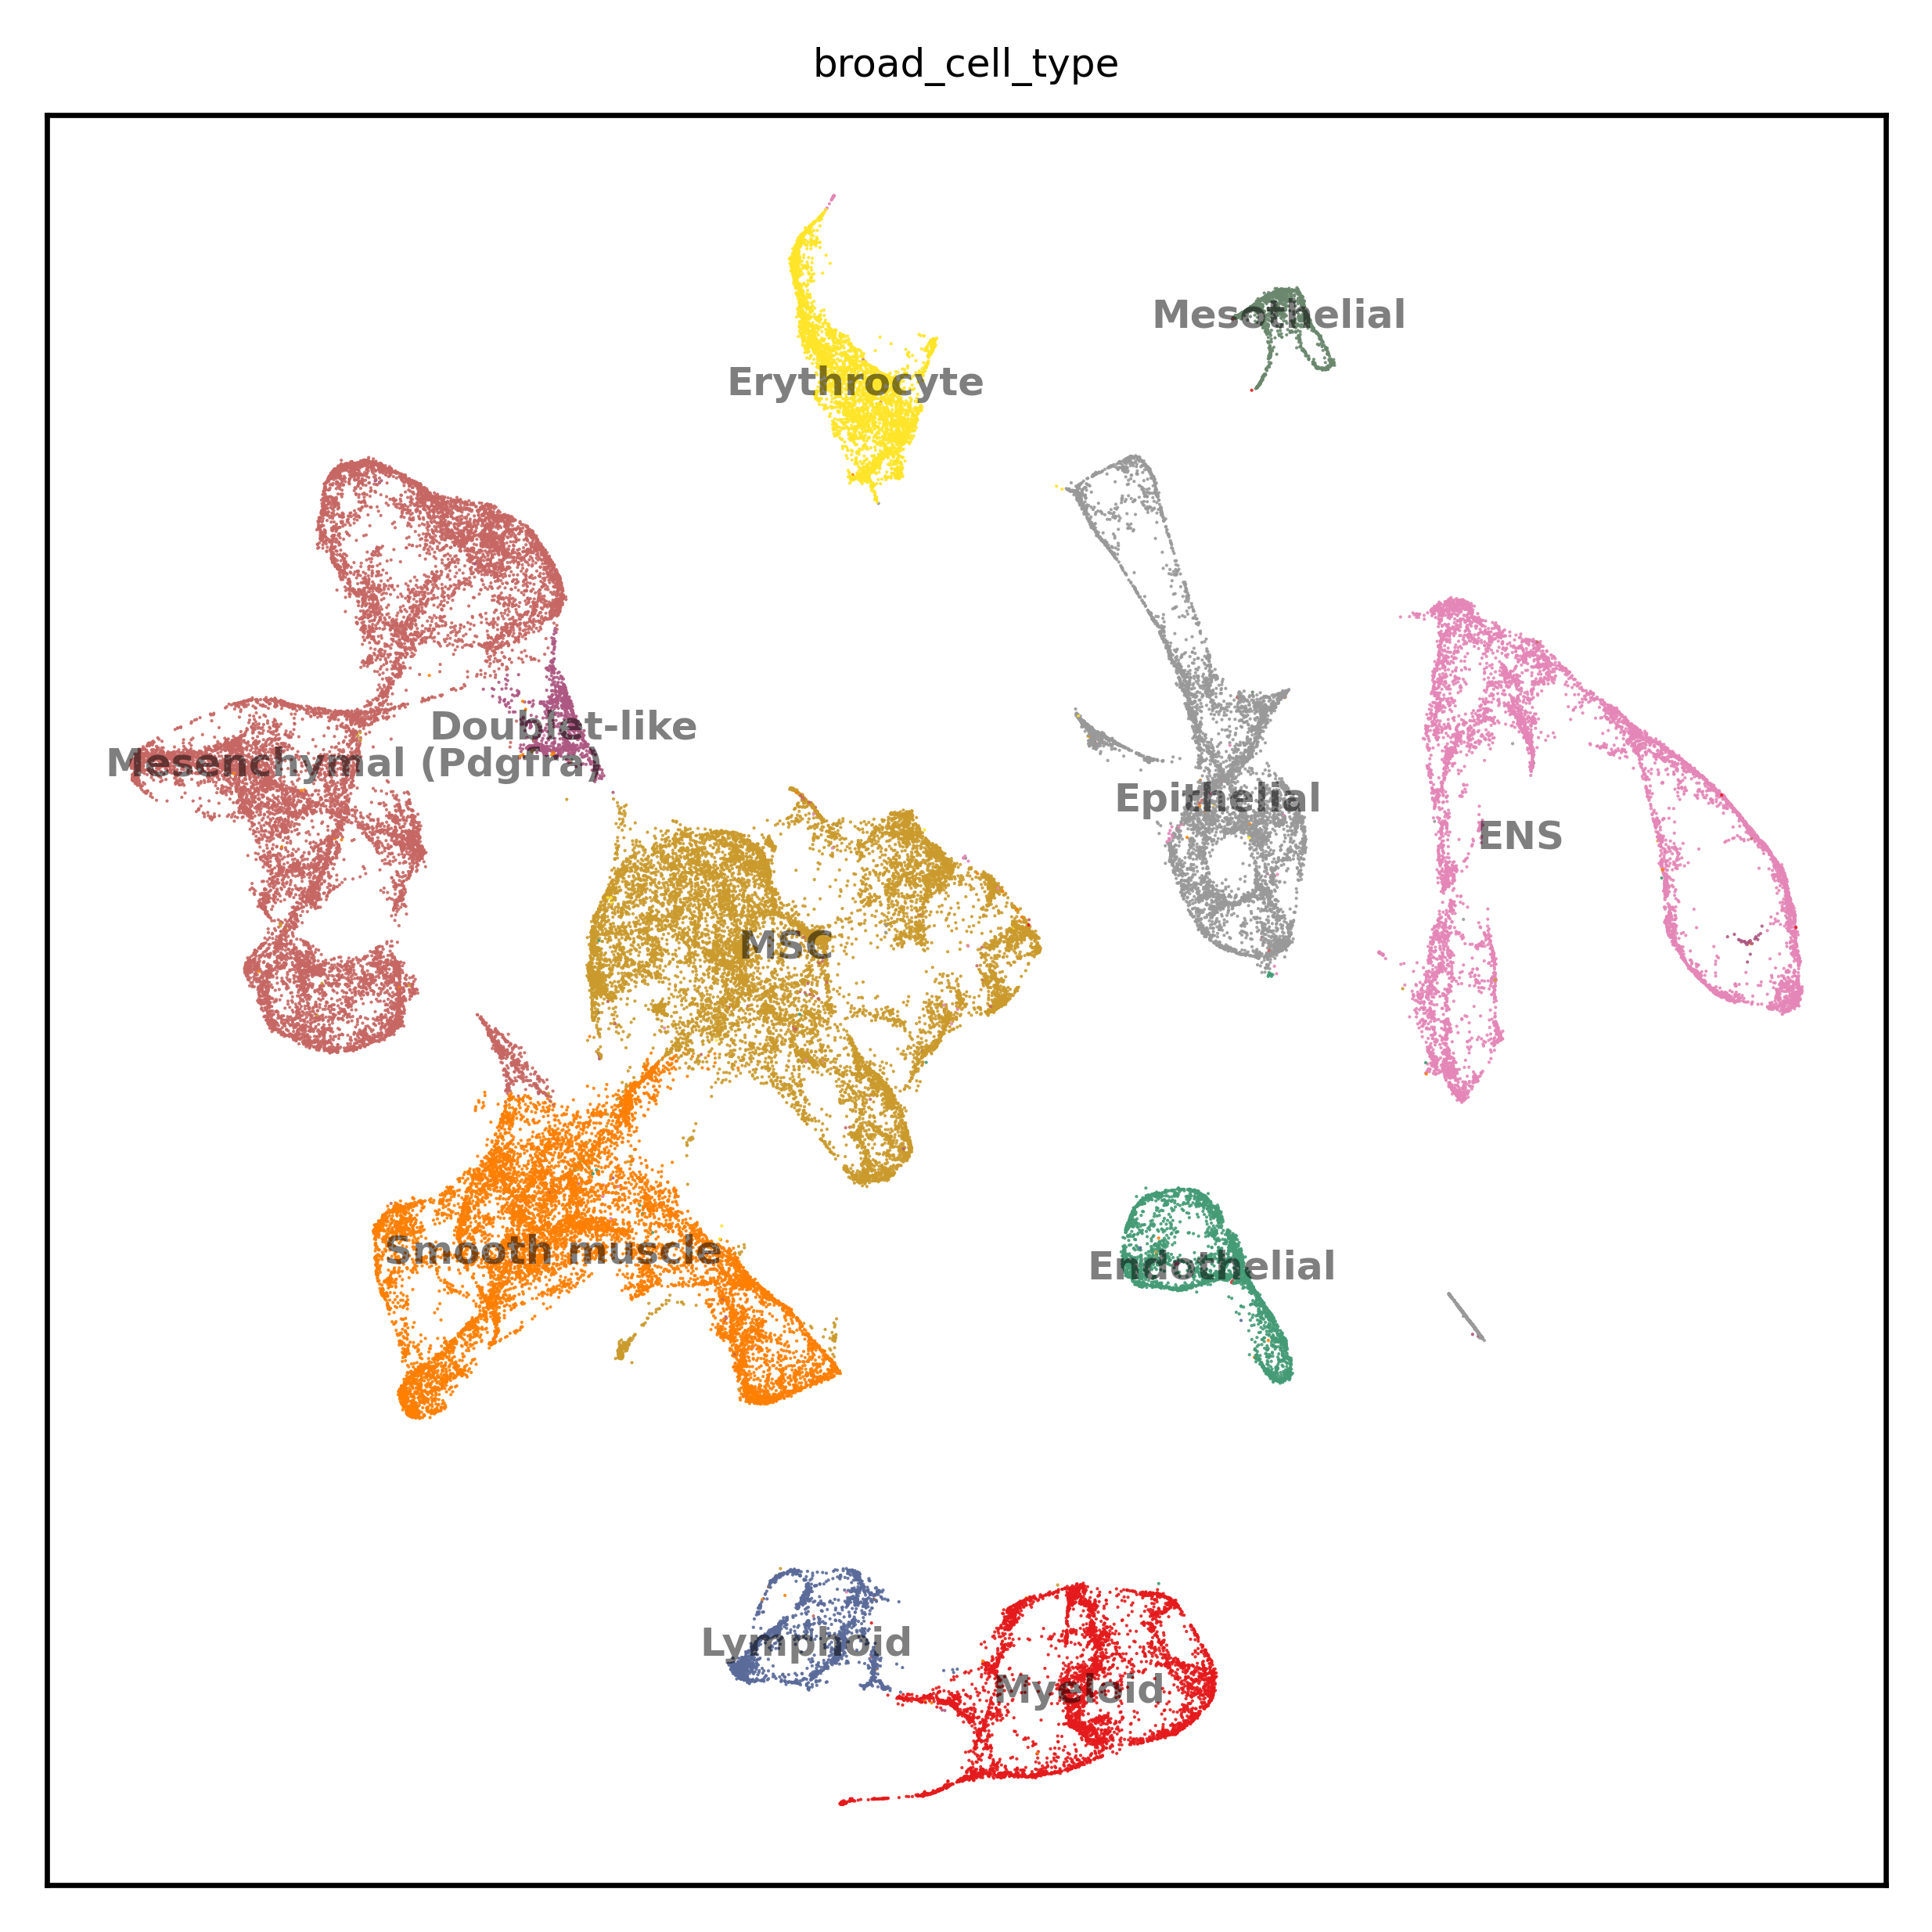

In [6]:
# basis = 'concord_hcl'
basis = 'concord_knn'
show_basis = basis + '_UMAP'
show_cols = ['broad_cell_type']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(4,4), dpi=600, ncols=1, font_size=6, point_size=1, legend_loc="on data",
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_embedding.svg"
)

----

In [7]:
# load the adata_subset from previous analysis: loop in epithelial cells and loop in endothelial cells
adata_endo_loop = sc.read_h5ad("../save/gut_dev_Huycke-Aug06-2301/gut_dev_Huycke_Jul17-1902_endothelial_loop.h5ad")
adata_epi_loop = sc.read_h5ad("../save/gut_dev_Huycke-Aug06-2301/gut_dev_Huycke_Jul17-1902_epithelial_loop.h5ad")
adata_smc_loop = sc.read_h5ad("../save/gut_dev_Huycke-Aug08-0055/gut_dev_Huycke_Jul17-1902_Smooth muscle_loop.h5ad")

In [8]:
print(adata)
print(adata_endo_loop)
print(adata_epi_loop)
print(adata_smc_loop)

AnnData object with n_obs × n_vars = 65468 × 18701
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.5', 'seurat_clusters', 'PercentMito', 'RNA_snn_res.1', 'LaneID', 'MULTI', 'SinDubNeg', 'Age', 'Mouse', 'SegPos', 'RNA_snn_res.5', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'Age_Mouse', 'Age_Pos', 'CellType_Coarse', 'SCT_snn_res.0.8', 'Classification', 'MouseAge', 'SegmentPos', 'MouseAge_combined', 'batch', 'mes_subtype', 'cell_type', 'epi_subtype', 'mes_BN', 'tcf_signaling_response_wnt_score', 'epi_wnt_group', 'MitoFraction', 'seg_classify', 'S_score', 'G2M_score', 'phase', 'broad_cell_type', 'stage', 'leiden_global_Concord', 'mac_subtype'
    var: 'gene_short_name'
    uns: 'LaneID_colors', 'MouseAge_combined_colors', 'batch_colors', 'broad_cell_type_colors', 'cell_type_colors', 'epi_subtype_colors', 'leiden_global_Concord', 'leiden_global_Concord_colors', 'log1p', 'mes_subtype_colors', 'neighbors', 'phase_colors', 'seg_classify_colors', 'stage_colors'
    obsm: 

In [62]:
# Create a Series mapping cell names to their loop category
import pandas as pd

# Initialize all cells as 'Others'
loop_status = pd.Series("Others", index=adata.obs_names)

# Set status for cells in endo_loop
# loop_status.loc[adata_endo_loop.obs_names] = "endo_loop"

# Set status for cells in epi_loop
loop_status.loc[adata_epi_loop.obs_names] = "epi_loop"

# Set status for cells in smc_loop
loop_status.loc[adata_smc_loop.obs_names] = "smc_loop"

# Assign it to adata.obs
adata.obs["loop_defined"] = loop_status

In [63]:
adata.obs['loop_defined'].value_counts()

loop_defined
Others      56734
smc_loop     5216
epi_loop     3518
Name: count, dtype: int64

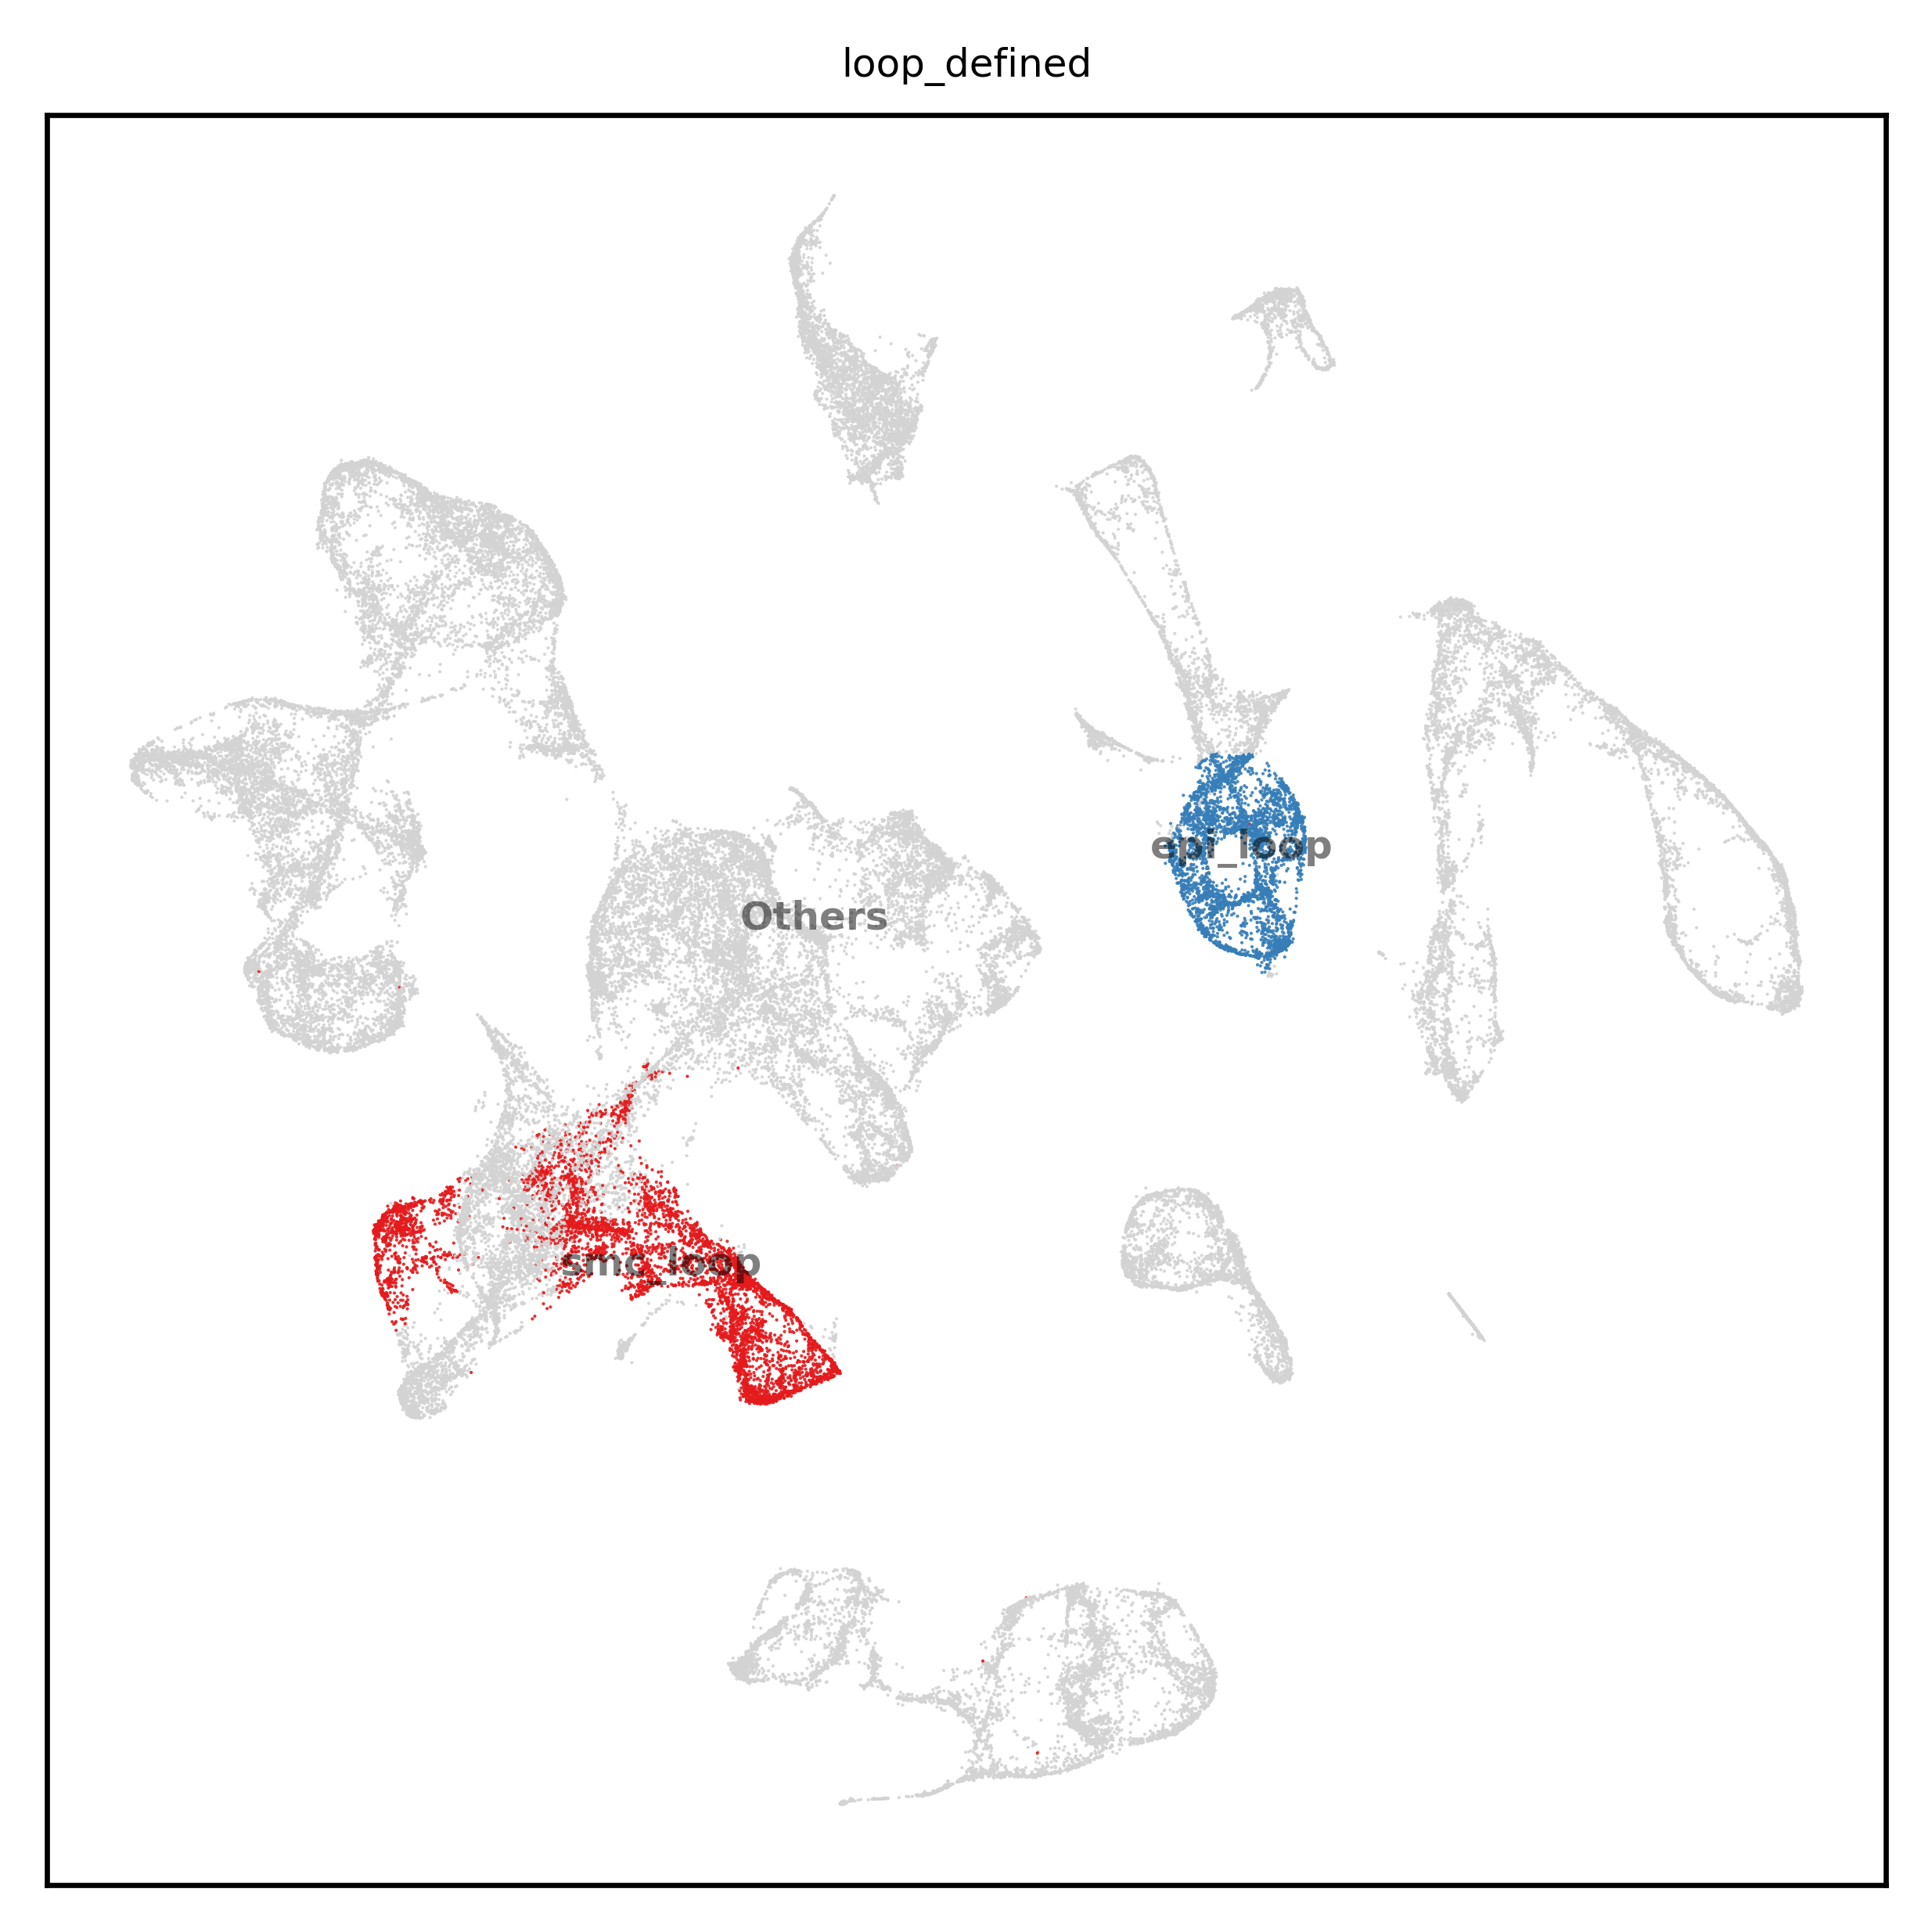

In [64]:
show_cols = ['loop_defined']

_, _, loop_defined_pal = ccd.pl.get_color_mapping(adata, 'loop_defined', pal='Set1', seed=seed)
loop_defined_pal["Others"] = 'lightgray'

pal = {"broad_cell_type": broad_celltype_pal,
    'phase': phase_pal,
    'loop_defined': loop_defined_pal}

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(4,4), dpi=600, ncols=1, font_size=6, point_size=1, legend_loc="on data",
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_{show_cols[0]}_embedding.svg"
)

In [65]:
color_by = 'loop_defined'

ccd.pl.plot_embedding_3d(
    adata, basis='concord_knn_UMAP_3D', color_by=color_by,
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_{color_by}_embedding_3d.html",
    point_size=1, opacity=1,
)

concord.plotting.pl_embedding - INFO - 3D plot saved to ../save/gut_dev_Huycke-Aug08-2012/gut_dev_Huycke_Jul17-1902_concord_knn_UMAP_loop_defined_embedding_3d_loop_defined.html


[Figure({
     'data': [{'hovertemplate': 'loop_defined=Others<br>DIM1=%{x}<br>DIM2=%{y}<br>DIM3=%{z}<extra></extra>',
               'legendgroup': 'Others',
               'marker': {'color': 'lightgray', 'opacity': 1, 'size': 1, 'symbol': 'circle'},
               'mode': 'markers',
               'name': 'Others',
               'scene': 'scene',
               'showlegend': True,
               'type': 'scatter3d',
               'x': {'bdata': ('jgaZQGflWkCs3GtAEnReQJ70gkCQUm' ... 'BDvmRAtzp3QSgexEDrOuRA+1VeQQ=='),
                     'dtype': 'f4'},
               'y': {'bdata': ('IUuVQMJ3mUCm4aFAWdiQQGkTkUDCiJ' ... 'Fh/JFAYAw3QbJH+L8IOaG/MYpRQQ=='),
                     'dtype': 'f4'},
               'z': {'bdata': ('pAN7QEiH5EDmQ7xA3CbqQI5XiEB9vN' ... 'DuP+FAuNEFwESBKUBgDQJBGTYTQQ=='),
                     'dtype': 'f4'}},
              {'hovertemplate': 'loop_defined=epi_loop<br>DIM1=%{x}<br>DIM2=%{y}<br>DIM3=%{z}<extra></extra>',
               'legendgroup': 'epi_loop',
  

palette_dict {'Others': 'lightgray', 'epi_loop': '#377eb8', 'smc_loop': '#e41a1c'}
color_by loop_defined
pal {'broad_cell_type': {'Doublet-like': '#ad5882', 'ENS': '#e486b7', 'Endothelial': '#449b76', 'Epithelial': '#999999', 'Erythrocyte': '#ffe529', 'Lymphoid': '#5a6a99', 'MSC': '#ca9a2c', 'Mesenchymal (Pdgfra)': '#c66764', 'Mesothelial': '#6b886e', 'Myeloid': '#e41a1c', 'Smooth muscle': '#ff7f00'}, 'phase': {'G1': '#4daf4a', 'G2M': '#377eb8', 'S': '#e41a1c'}, 'loop_defined': {'Others': 'lightgray', 'epi_loop': '#377eb8', 'smc_loop': '#e41a1c'}}
cmap None
concord.plotting.pl_embedding - INFO - Saved 3D matplotlib plot for 'loop_defined' to ../save/gut_dev_Huycke-Aug08-2012/gut_dev_Huycke_Jul17-1902_concord_knn_UMAP_loop_defined_embedding_3d_view_rasterized.svg


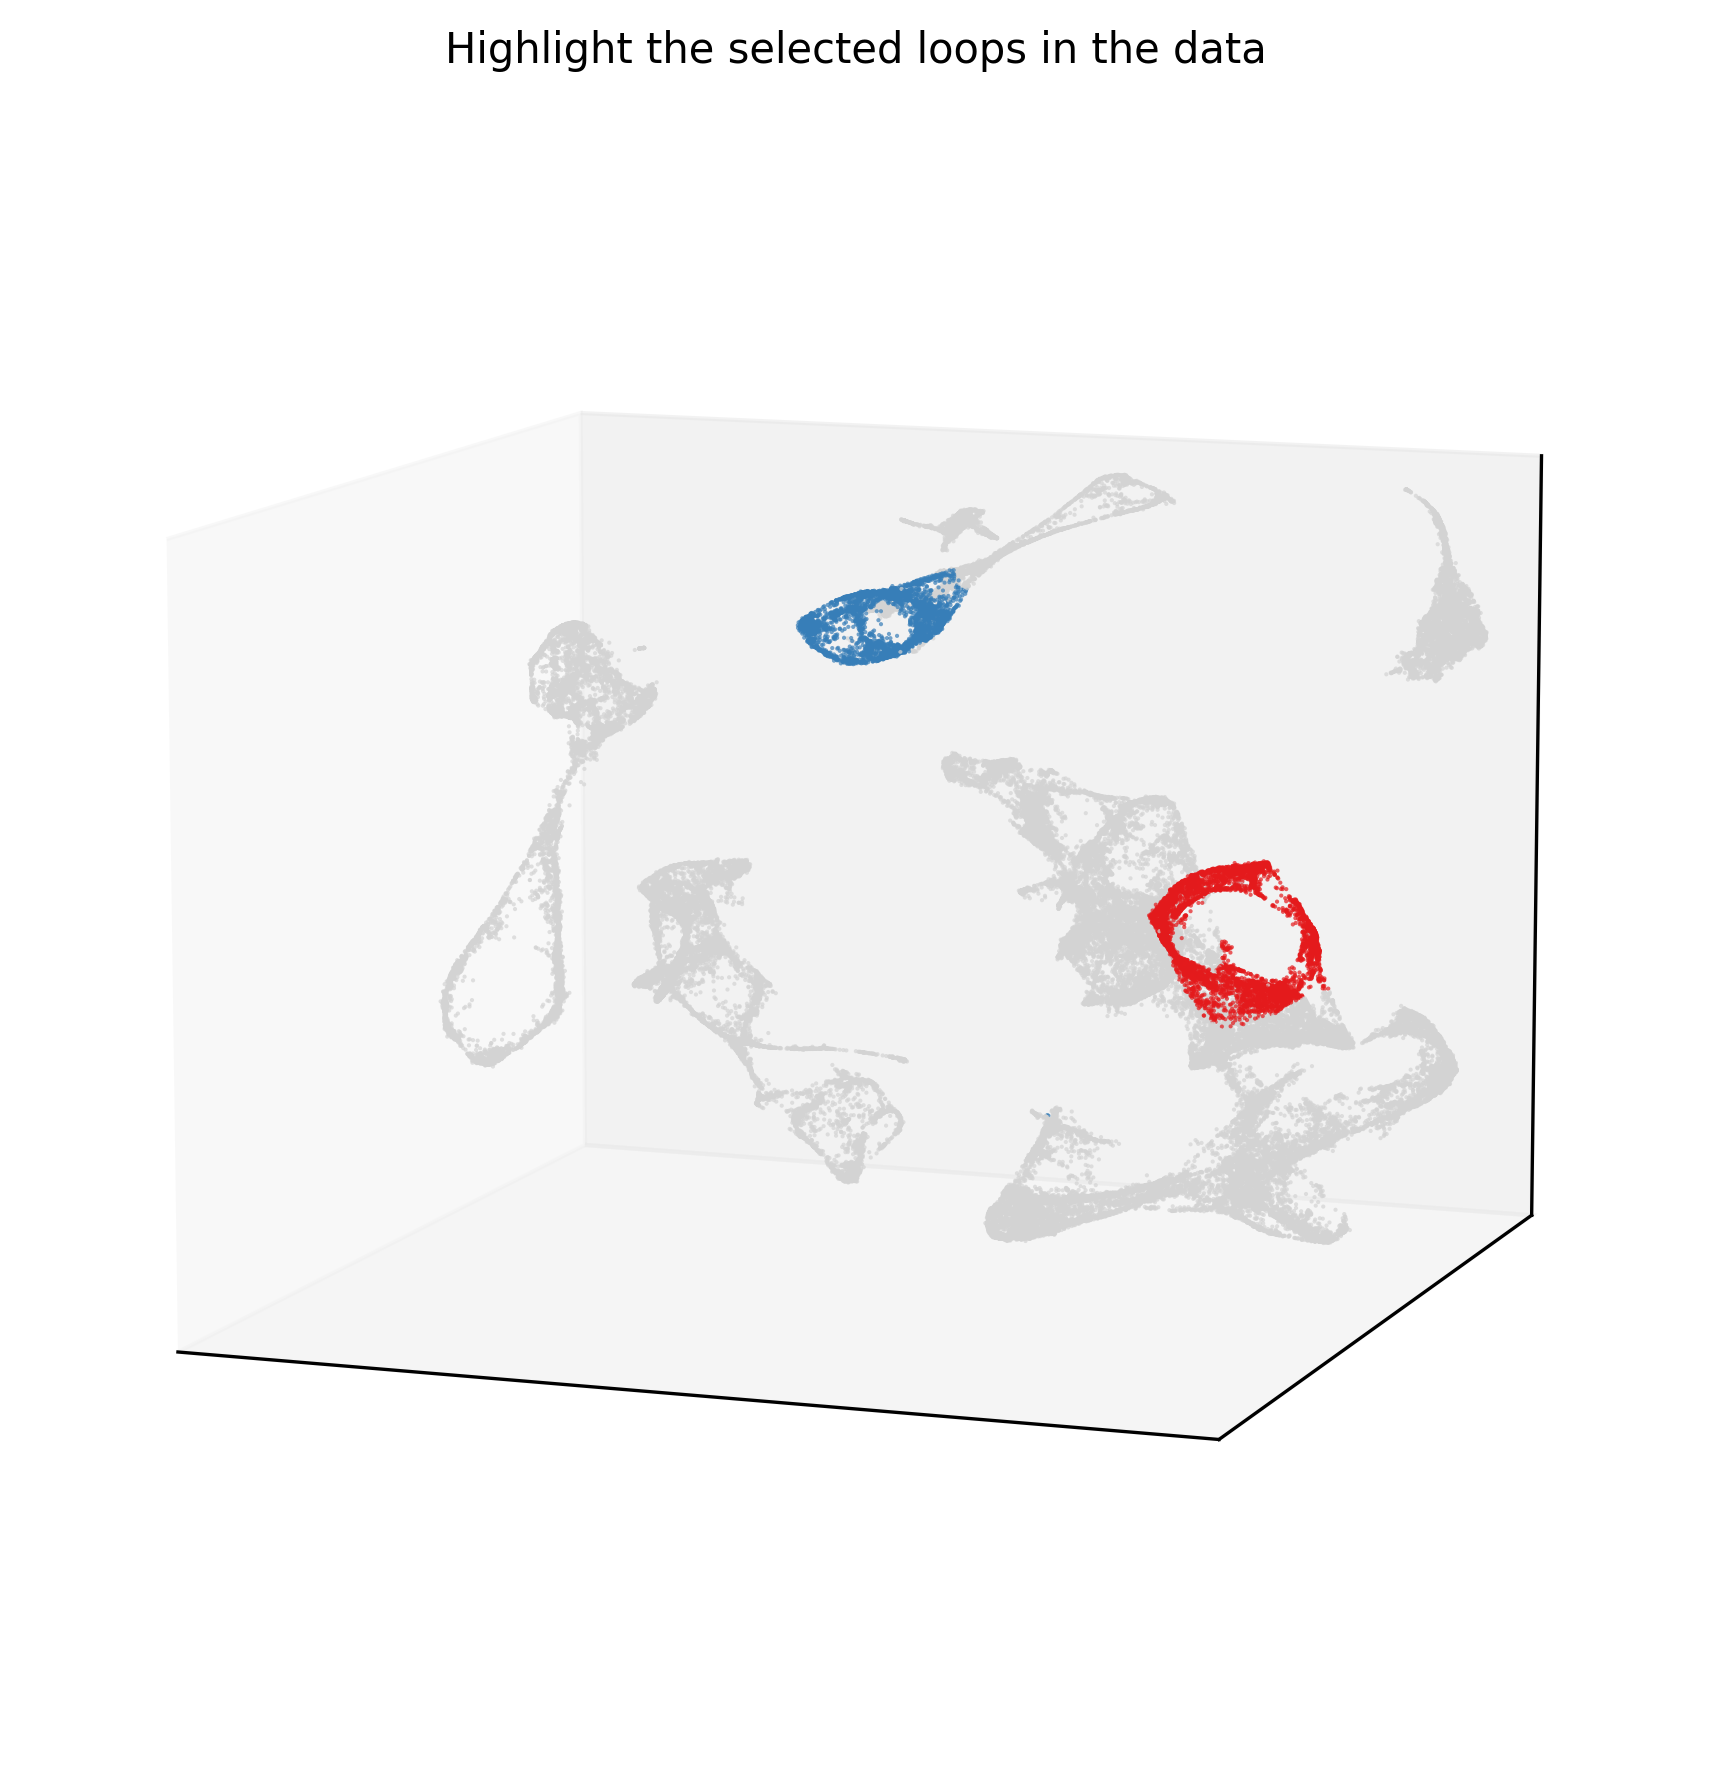

(<Figure size 1800x1800 with 1 Axes>,
 <Axes3D: title={'center': 'Highlight the selected loops in the data'}>)

In [136]:
color_by = 'loop_defined'

ccd.pl.plot_embedding_3d_matplotlib(
    adata, basis='concord_knn_UMAP_3D', color_by=color_by,
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_{color_by}_embedding_3d_view_rasterized.svg",
    point_size=1,

    # Appearance toggles
    title='Highlight the selected loops in the data',
    show_title=True,
    title_font_size=10,
    show_axis_labels=False,
    show_ticks=False,
    show_tick_labels=False,
    show_grid=False,

    # view angle parameters
    elev=10,    
    azim=110,
    zoom_factor=1,

    rasterized=True,
)

palette_dict {'Others': 'lightgray', 'epi_loop': '#377eb8', 'smc_loop': '#e41a1c'}
color_by loop_defined
pal {'broad_cell_type': {'Doublet-like': '#ad5882', 'ENS': '#e486b7', 'Endothelial': '#449b76', 'Epithelial': '#999999', 'Erythrocyte': '#ffe529', 'Lymphoid': '#5a6a99', 'MSC': '#ca9a2c', 'Mesenchymal (Pdgfra)': '#c66764', 'Mesothelial': '#6b886e', 'Myeloid': '#e41a1c', 'Smooth muscle': '#ff7f00'}, 'phase': {'G1': '#4daf4a', 'G2M': '#377eb8', 'S': '#e41a1c'}, 'loop_defined': {'Others': 'lightgray', 'epi_loop': '#377eb8', 'smc_loop': '#e41a1c'}}
cmap None
concord.plotting.pl_embedding - INFO - Saved 3D matplotlib plot for 'loop_defined' to ../save/gut_dev_Huycke-Aug08-2012/gut_dev_Huycke_Jul17-1902_concord_knn_UMAP_loop_defined_embedding_3d_view_with_ticks.pdf


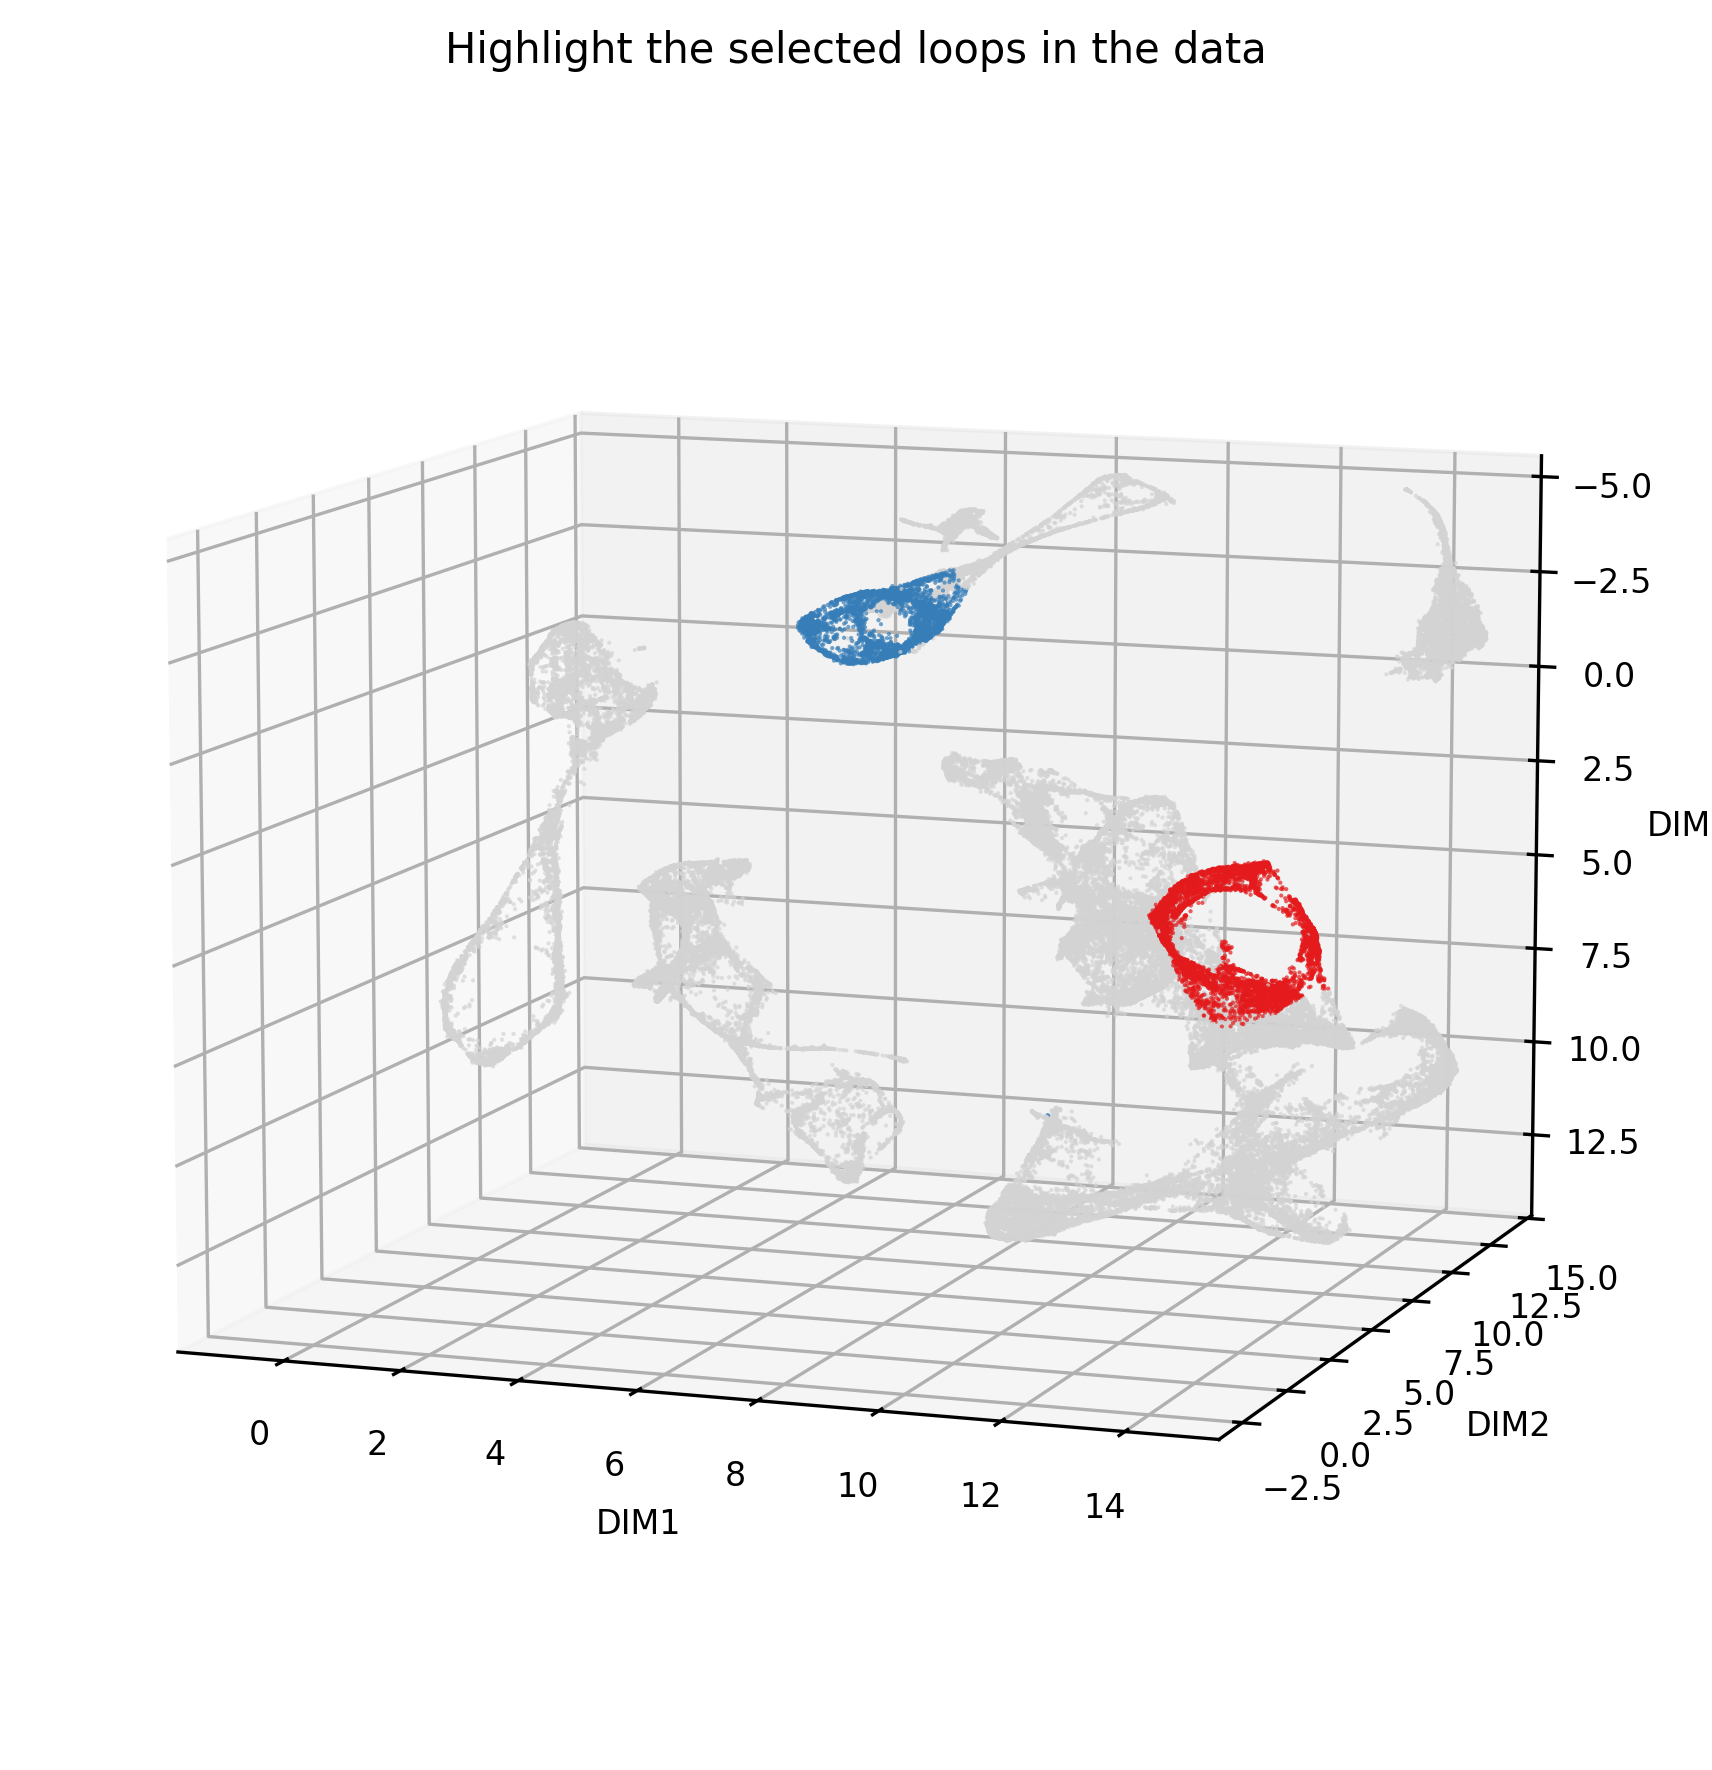

(<Figure size 1800x1800 with 1 Axes>,
 <Axes3D: title={'center': 'Highlight the selected loops in the data'}, xlabel='DIM1', ylabel='DIM2', zlabel='DIM3'>)

In [111]:
color_by = 'loop_defined'

ccd.pl.plot_embedding_3d_matplotlib(
    adata, basis='concord_knn_UMAP_3D', color_by=color_by,
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_{color_by}_embedding_3d_view_with_ticks.pdf",
    point_size=1,

    # Appearance toggles
    title='Highlight the selected loops in the data',
    show_title=True,
    title_font_size=10,
    show_axis_labels=True,
    show_ticks=True,
    show_tick_labels=True,
    show_grid=True,

    # view angle parameters
    elev=10,    
    azim=110,
    zoom_factor=1,
)

In [82]:
# get the indeces of cells in the endo_loop
endo_loop_indices = adata_endo_loop.obs_names

In [83]:
endo_loop_indices

Index(['AAACCCAAGACCGCCT-1-clean', 'ACACAGTTCTTCTGGC-1-clean',
       'AGATAGACACGGTGCT-1-clean', 'AGGACGATCCTGCTAC-1-clean',
       'ATTCCATCAGCACCCA-1-clean', 'CAGAGCCGTTGTTGTG-1-clean',
       'CCCGAAGTCGCCAGTG-1-clean', 'CCGTTCAAGTGCCAGA-1-clean',
       'CTATAGGCACAGCGCT-1-clean', 'GACTCTCAGTAAGACT-1-clean',
       ...
       'TTTCGATAGAATAACC-3-sct', 'TTTGACTCAGACTCTA-3-sct',
       'TTTGATCGTTGCTCCT-3-sct', 'TTTGGAGGTTGGGAAC-3-sct',
       'TTTGGTTAGATCGCCC-3-sct', 'TTTGGTTAGTTCGCAT-3-sct',
       'TTTGGTTGTACTGAGG-3-sct', 'TTTGGTTTCAGCAATC-3-sct',
       'TTTGTTGAGACCTTTG-3-sct', 'TTTGTTGCACGGAAGT-3-sct'],
      dtype='object', length=1966)

In [94]:
# add a column to adata.obs to store the adata_endo_loop.obs["loop_order"]
adata.obs["endo_loop_order"] = adata_endo_loop.obs["loop_order"]
# others label as NaN
adata.obs["endo_loop_order"].fillna(value=np.nan, inplace=True)

# add a column to adata.obs to store the adata_epi_loop.obs["loop_order"]
adata.obs["epi_loop_order"] = adata_epi_loop.obs["loop_order"]
# others label as NaN
adata.obs["epi_loop_order"].fillna(value=np.nan, inplace=True)

# add a column to adata.obs to store the adata_smc_loop.obs["loop_order"]
adata.obs["smc_loop_order"] = adata_smc_loop.obs["loop_order"]
# others label as NaN
adata.obs["smc_loop_order"].fillna(value=np.nan, inplace=True)

In [123]:
import matplotlib.pyplot as plt
import logging

def plot_embedding_3d_matplotlib(
    adata, 
    basis='encoded_UMAP', 
    color_by='batch', 
    pal=None,
    save_path=None, 
    point_size=3,
    alpha=0.7, 
    marker_style='o',          
    edge_color='none',         
    edge_width=0,              
    seed=42, 
    width=6, 
    height=6,
    dpi=300,
    show_legend=True,

    # Appearance toggles
    title=None,
    show_title=True,
    title_font_size=10,
    show_axis_labels=True,
    axis_label_font_size=8,
    show_ticks=True,
    show_tick_labels=True,
    tick_label_font_size=8,
    show_grid=False,

    # View angle
    elev=30,    
    azim=45,
    zoom_factor=0.5,
    box_aspect_ratio=None,

    # axis parameters
    xlim=None,
    ylim=None,
    zlim=None,

    # Highlight indices
    highlight_indices=None,
    highlight_color='black',
    highlight_size=20,
    highlight_alpha=1.0,

    # Quantile color for vmax
    vmax_quantile=None,

    # New parameter to rasterize points
    rasterized=False,

    # If you want to plot into an existing axis
    ax=None
    ):
    if basis not in adata.obsm:
        raise KeyError(f"Embedding key '{basis}' not found in adata.obsm")

    embedding = adata.obsm[basis]

    # if not isinstance(embedding, np.ndarray):
    #     embedding = np.array(embedding)
    if embedding.shape[1] < 3:
        raise ValueError(f"Embedding '{basis}' must have at least 3 dimensions")
    
    # Convert embedding to pandas DataFrame and match with adata.obs
    embedding = pd.DataFrame(embedding[:, :3], columns=['DIM1', 'DIM2', 'DIM3'])
    embedding.index = adata.obs.index

    df = adata.obs.copy()
    df['DIM1'] = embedding['DIM1']
    df['DIM2'] = embedding['DIM2']
    df['DIM3'] = embedding['DIM3']

    # Get color mapping
    # data_col, cmap, palette_dict = get_color_mapping(adata, color_by, pal, seed=seed)

    palette_dict = None
    data_col = adata.obs[color_by].copy()
    cmap = 'viridis' 

    print("palette_dict", palette_dict)
    print("color_by", color_by)
    print("pal", pal)   
    print("cmap", cmap)
    # Create fig/ax if not provided
    created_new_fig = False
    if ax is None:
        fig = plt.figure(figsize=(width, height), dpi=dpi)
        ax = fig.add_subplot(111, projection='3d')
        created_new_fig = True
    else:
        fig = ax.figure

    ax.view_init(elev=elev, azim=azim)
    if box_aspect_ratio is not None:
        ax.set_box_aspect(box_aspect_ratio)

    # Title
    if show_title:
        title_str = title if title else f"3D Embedding colored by '{color_by}'"
        ax.set_title(title_str, fontsize=title_font_size)

    # Convert categorical data to colors
    if pd.api.types.is_numeric_dtype(data_col):
        if vmax_quantile is not None:
            vmax = np.percentile(data_col, vmax_quantile * 100)
            print(f"Using vmax={vmax} based on quantile {vmax_quantile}")
            data_col = np.clip(data_col, 0, vmax)
        colors = data_col
    else:
        colors = data_col.astype('category').map(palette_dict)



    # **Step 1: Plot all points as transparent background (establish depth ordering)**
    ax.scatter(
        df['DIM1'], df['DIM2'], df['DIM3'],
        c='none',  # Invisible, but included for depth sorting
        alpha=0, 
        s=point_size,
        marker=marker_style,
        edgecolors='none',
        rasterized=rasterized,
        zorder=1
    )

    # **Step 2: Plot non-highlighted points**
    if highlight_indices is not None:
        non_highlight_mask = ~df.index.isin(highlight_indices)
    else:
        non_highlight_mask = np.ones(len(df), dtype=bool)


    ax.scatter(
        df.loc[non_highlight_mask, 'DIM1'],
        df.loc[non_highlight_mask, 'DIM2'],
        df.loc[non_highlight_mask, 'DIM3'],
        c=colors[non_highlight_mask],
        cmap=cmap,
        alpha=alpha,
        s=point_size,
        marker=marker_style,
        edgecolors=edge_color,
        linewidths=edge_width,
        rasterized=rasterized,
        zorder=2  # Lower than highlights
    )

    # **Step 3: Plot highlighted points last, ensuring they appear on top**
    if highlight_indices is not None:
        ax.scatter(
            df.loc[highlight_indices, 'DIM1'],
            df.loc[highlight_indices, 'DIM2'],
            df.loc[highlight_indices, 'DIM3'],
            c=highlight_color,
            cmap=cmap,
            s=highlight_size,
            alpha=highlight_alpha,
            marker=marker_style,
            edgecolors=edge_color,
            linewidths=edge_width,
            rasterized=rasterized,  # Ensure no compression artifacts for highlights
            zorder=3  # Ensures they are plotted last
        )

    # Axis labels
    if show_axis_labels:
        ax.set_xlabel("DIM1", fontsize=axis_label_font_size)
        ax.set_ylabel("DIM2", fontsize=axis_label_font_size)
        ax.set_zlabel("DIM3", fontsize=axis_label_font_size)
    else:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_zlabel("")

    # If user provided manual limits, use them as-is.
    # Otherwise, compute via zoom_factor like before.
    x_min, x_max = df['DIM1'].min(), df['DIM1'].max()
    y_min, y_max = df['DIM2'].min(), df['DIM2'].max()
    z_min, z_max = df['DIM3'].min(), df['DIM3'].max()

    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        x_range = (x_max - x_min) * zoom_factor
        ax.set_xlim([x_min + x_range, x_max - x_range])
        print(f"Setting xlim to {ax.get_xlim()} based on zoom_factor {zoom_factor}")

    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        y_range = (y_max - y_min) * zoom_factor
        ax.set_ylim([y_min + y_range, y_max - y_range])
        print(f"Setting ylim to {ax.get_ylim()} based on zoom_factor {zoom_factor}")

    if zlim is not None:
        ax.set_zlim(zlim)
    else:
        z_range = (z_max - z_min) * zoom_factor
        ax.set_zlim([z_min + z_range, z_max - z_range])
        print(f"Setting zlim to {ax.get_zlim()} based on zoom_factor {zoom_factor}")

    # Grid
    ax.grid(show_grid)

    # Ticks
    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    # Tick labels
    if not show_tick_labels:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    else:
        ax.tick_params(labelsize=tick_label_font_size)

    if created_new_fig:
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Saved 3D matplotlib plot for '{color_by}' to {save_path}")
        plt.show()

    return fig, ax

palette_dict None
color_by smc_loop_order
pal {'broad_cell_type': {'Doublet-like': '#ad5882', 'ENS': '#e486b7', 'Endothelial': '#449b76', 'Epithelial': '#999999', 'Erythrocyte': '#ffe529', 'Lymphoid': '#5a6a99', 'MSC': '#ca9a2c', 'Mesenchymal (Pdgfra)': '#c66764', 'Mesothelial': '#6b886e', 'Myeloid': '#e41a1c', 'Smooth muscle': '#ff7f00'}, 'phase': {'G1': '#4daf4a', 'G2M': '#377eb8', 'S': '#e41a1c'}, 'loop_defined': {'Others': 'lightgray', 'epi_loop': '#377eb8', 'smc_loop': '#e41a1c'}}
cmap viridis
Saved 3D matplotlib plot for 'smc_loop_order' to ../save/gut_dev_Huycke-Aug08-2012/gut_dev_Huycke_Jul17-1902_concord_knn_UMAP_smc_loop_order_embedding_3d_view.svg


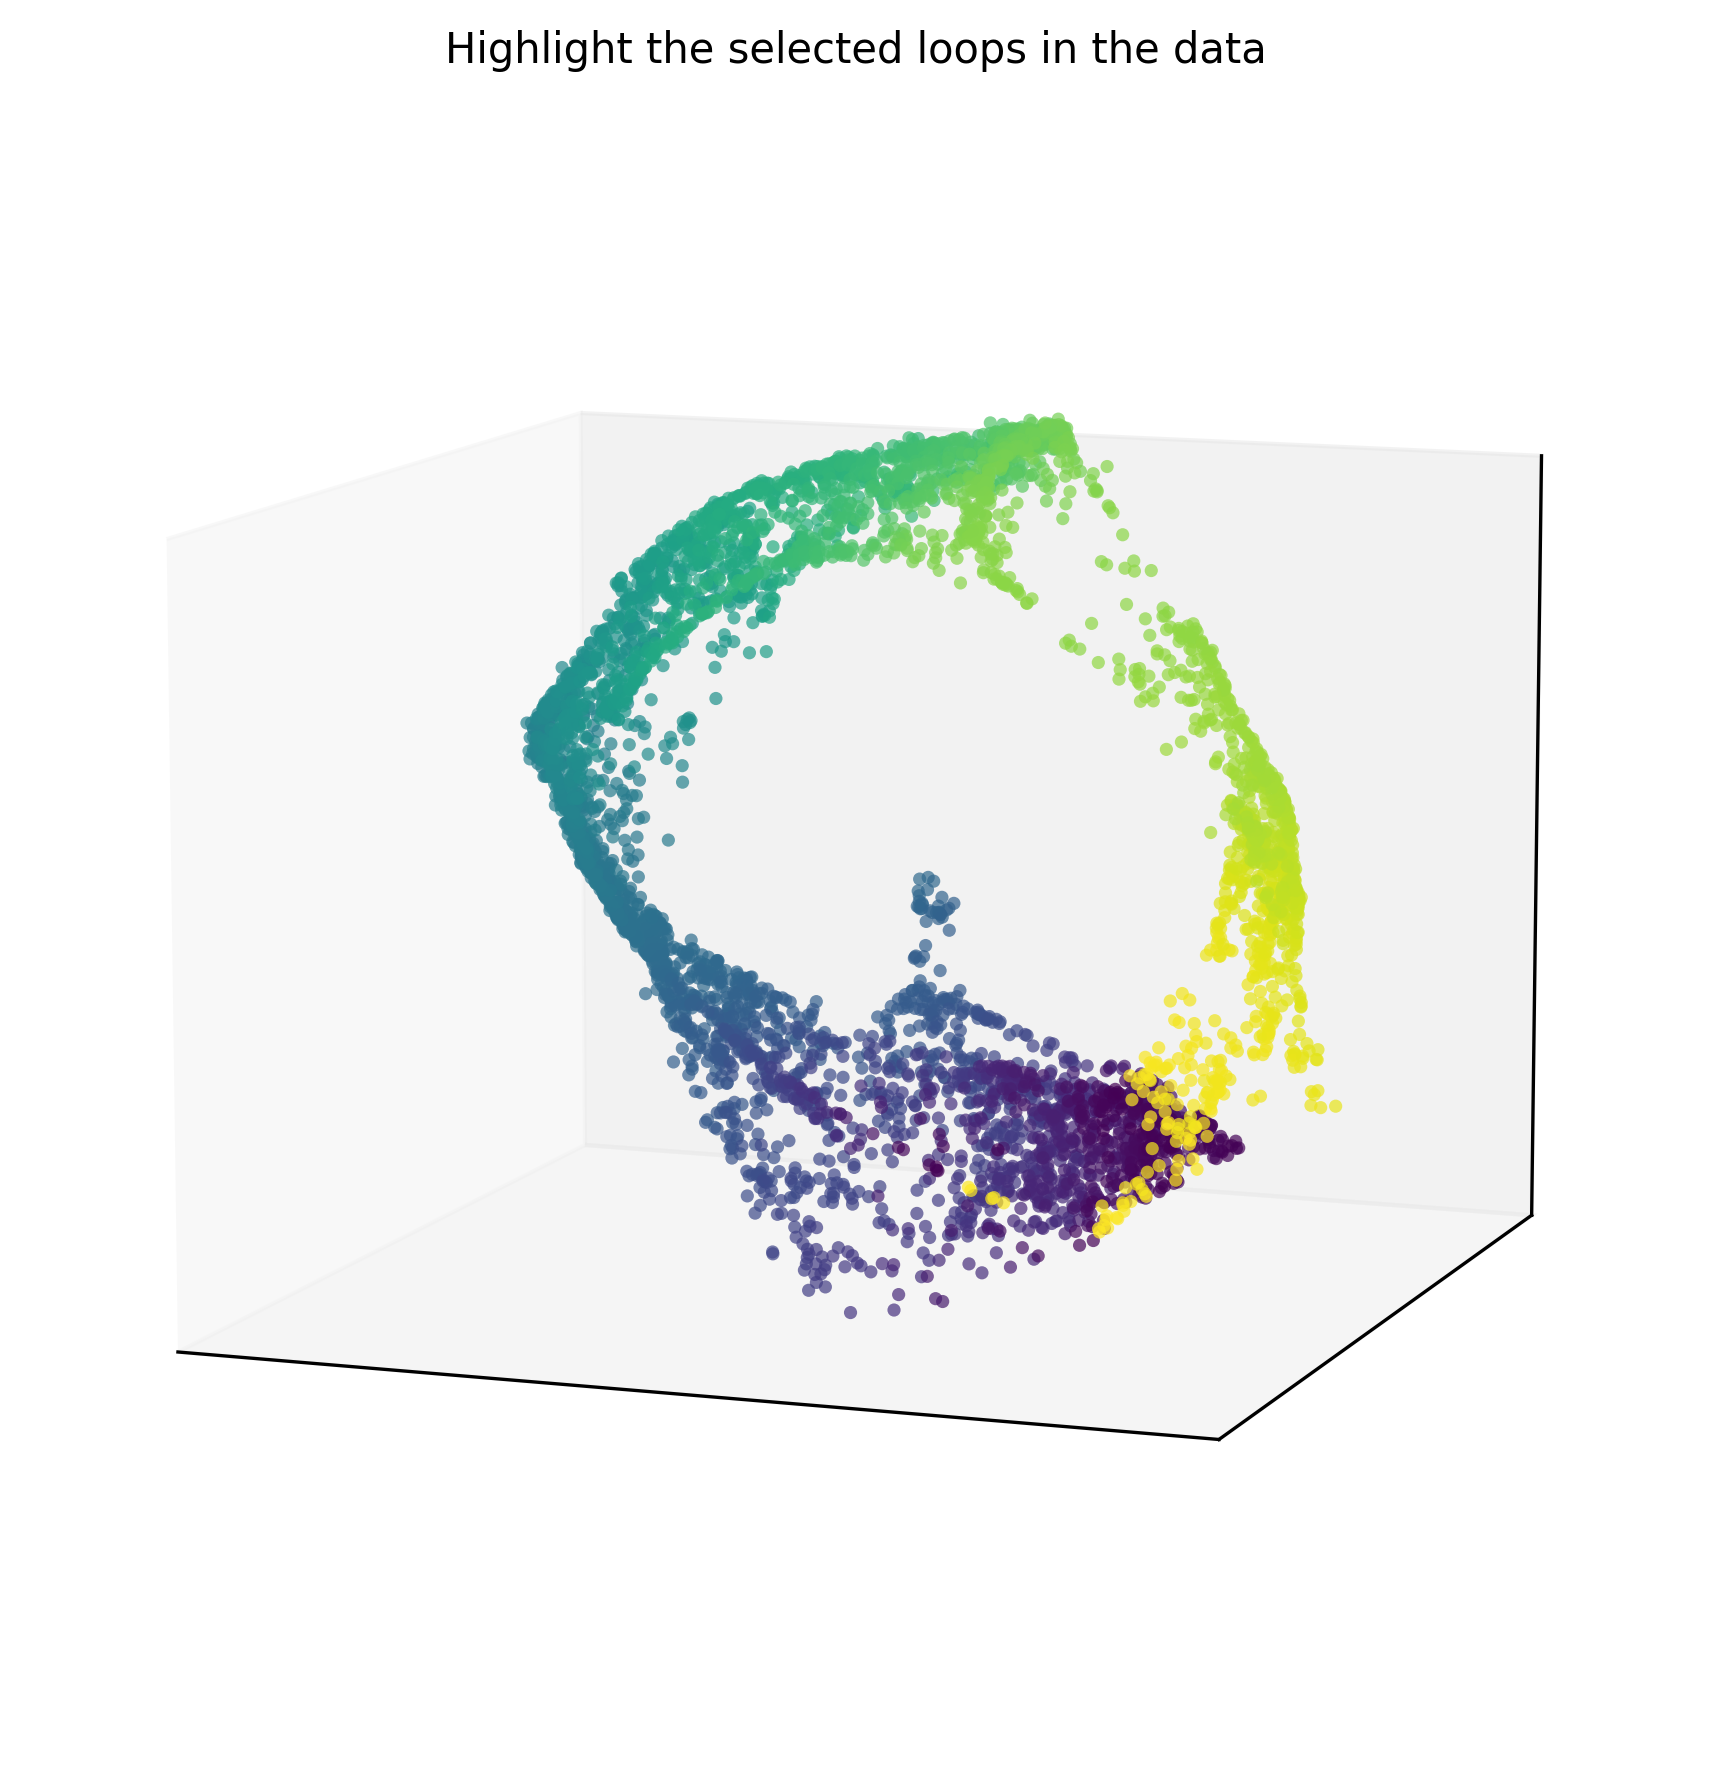

(<Figure size 1800x1800 with 1 Axes>,
 <Axes3D: title={'center': 'Highlight the selected loops in the data'}>)

In [131]:
color_by = 'smc_loop_order'

plot_embedding_3d_matplotlib(
    adata, basis='concord_knn_UMAP_3D', color_by=color_by,
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_{color_by}_embedding_3d_view.svg",
    point_size=10,

    # Appearance toggles
    title='Highlight the selected loops in the data',
    show_title=True,
    title_font_size=10,
    show_axis_labels=False,
    show_ticks=False,
    show_tick_labels=False,
    show_grid=False,

    # view angle parameters
    elev=10,    
    azim=110,
    zoom_factor=1,

    # axis parameters
    xlim=[14, 10],
    ylim=[10, 6],
    zlim=[8, 4],

)

palette_dict None
color_by epi_loop_order
pal {'broad_cell_type': {'Doublet-like': '#ad5882', 'ENS': '#e486b7', 'Endothelial': '#449b76', 'Epithelial': '#999999', 'Erythrocyte': '#ffe529', 'Lymphoid': '#5a6a99', 'MSC': '#ca9a2c', 'Mesenchymal (Pdgfra)': '#c66764', 'Mesothelial': '#6b886e', 'Myeloid': '#e41a1c', 'Smooth muscle': '#ff7f00'}, 'phase': {'G1': '#4daf4a', 'G2M': '#377eb8', 'S': '#e41a1c'}, 'loop_defined': {'Others': 'lightgray', 'epi_loop': '#377eb8', 'smc_loop': '#e41a1c'}}
cmap viridis
Saved 3D matplotlib plot for 'epi_loop_order' to ../save/gut_dev_Huycke-Aug08-2012/gut_dev_Huycke_Jul17-1902_concord_knn_UMAP_epi_loop_order_embedding_3d_view.svg


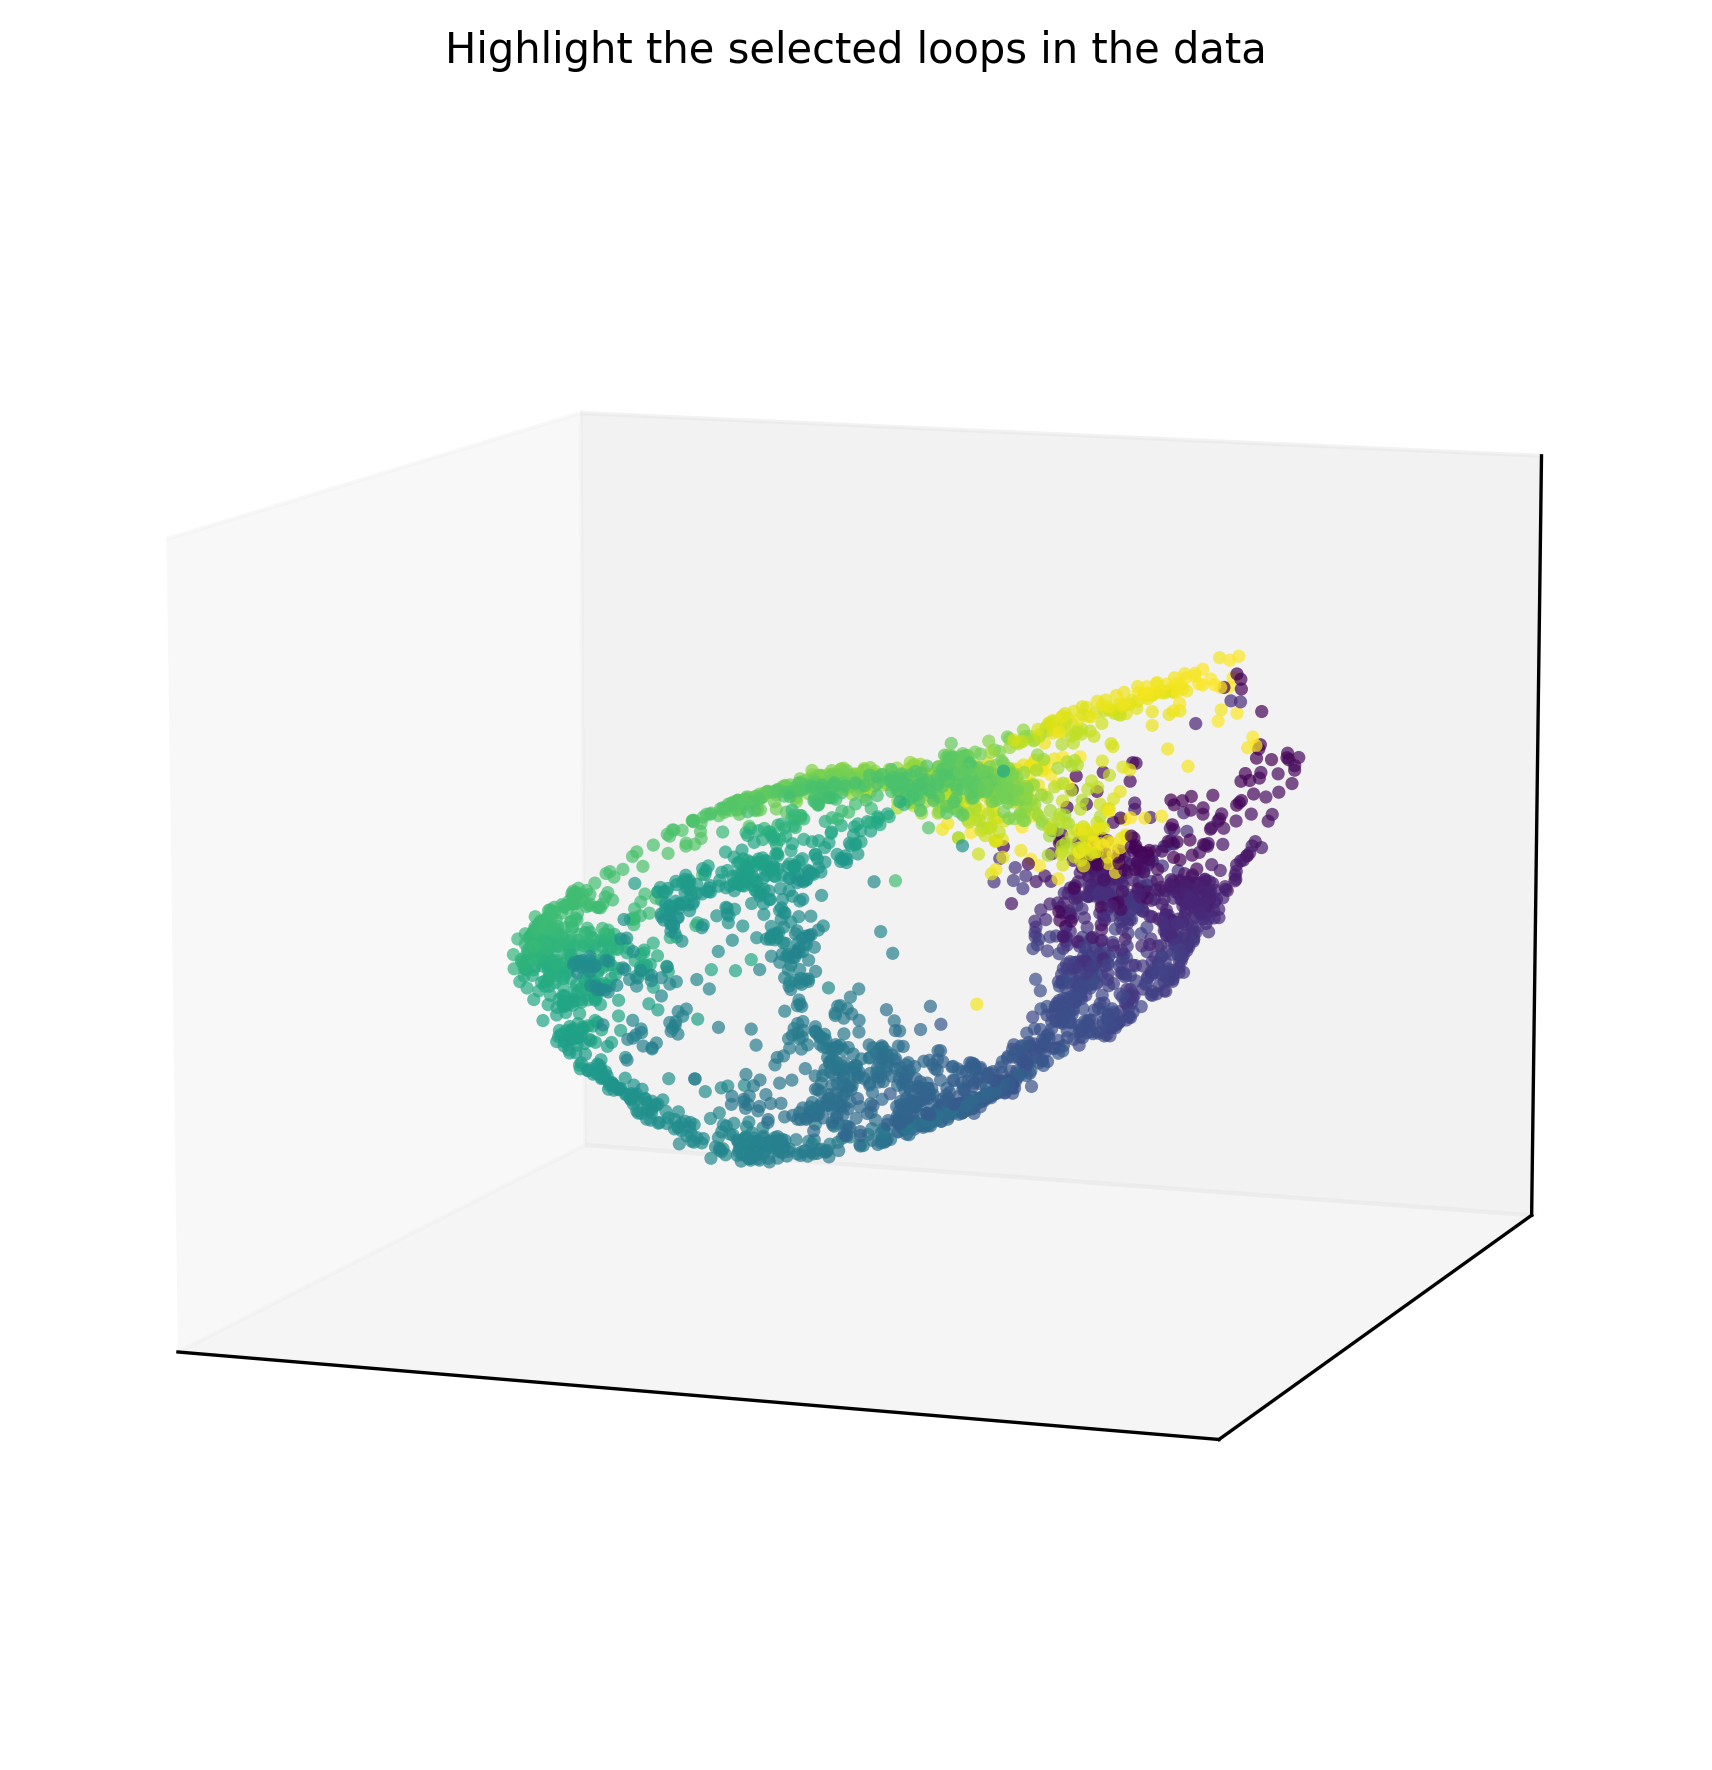

(<Figure size 1800x1800 with 1 Axes>,
 <Axes3D: title={'center': 'Highlight the selected loops in the data'}>)

In [132]:
color_by = 'epi_loop_order'

plot_embedding_3d_matplotlib(
    adata, basis='concord_knn_UMAP_3D', color_by=color_by,
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_{color_by}_embedding_3d_view.svg",
    point_size=10,

    # Appearance toggles
    title='Highlight the selected loops in the data',
    show_title=True,
    title_font_size=10,
    show_axis_labels=False,
    show_ticks=False,
    show_tick_labels=False,
    show_grid=False,

    # view angle parameters
    elev=10,    
    azim=110,
    zoom_factor=1,

    # axis parameters
    xlim=[8, 4],
    ylim=[10, 6],
    zlim=[0, -4],

)

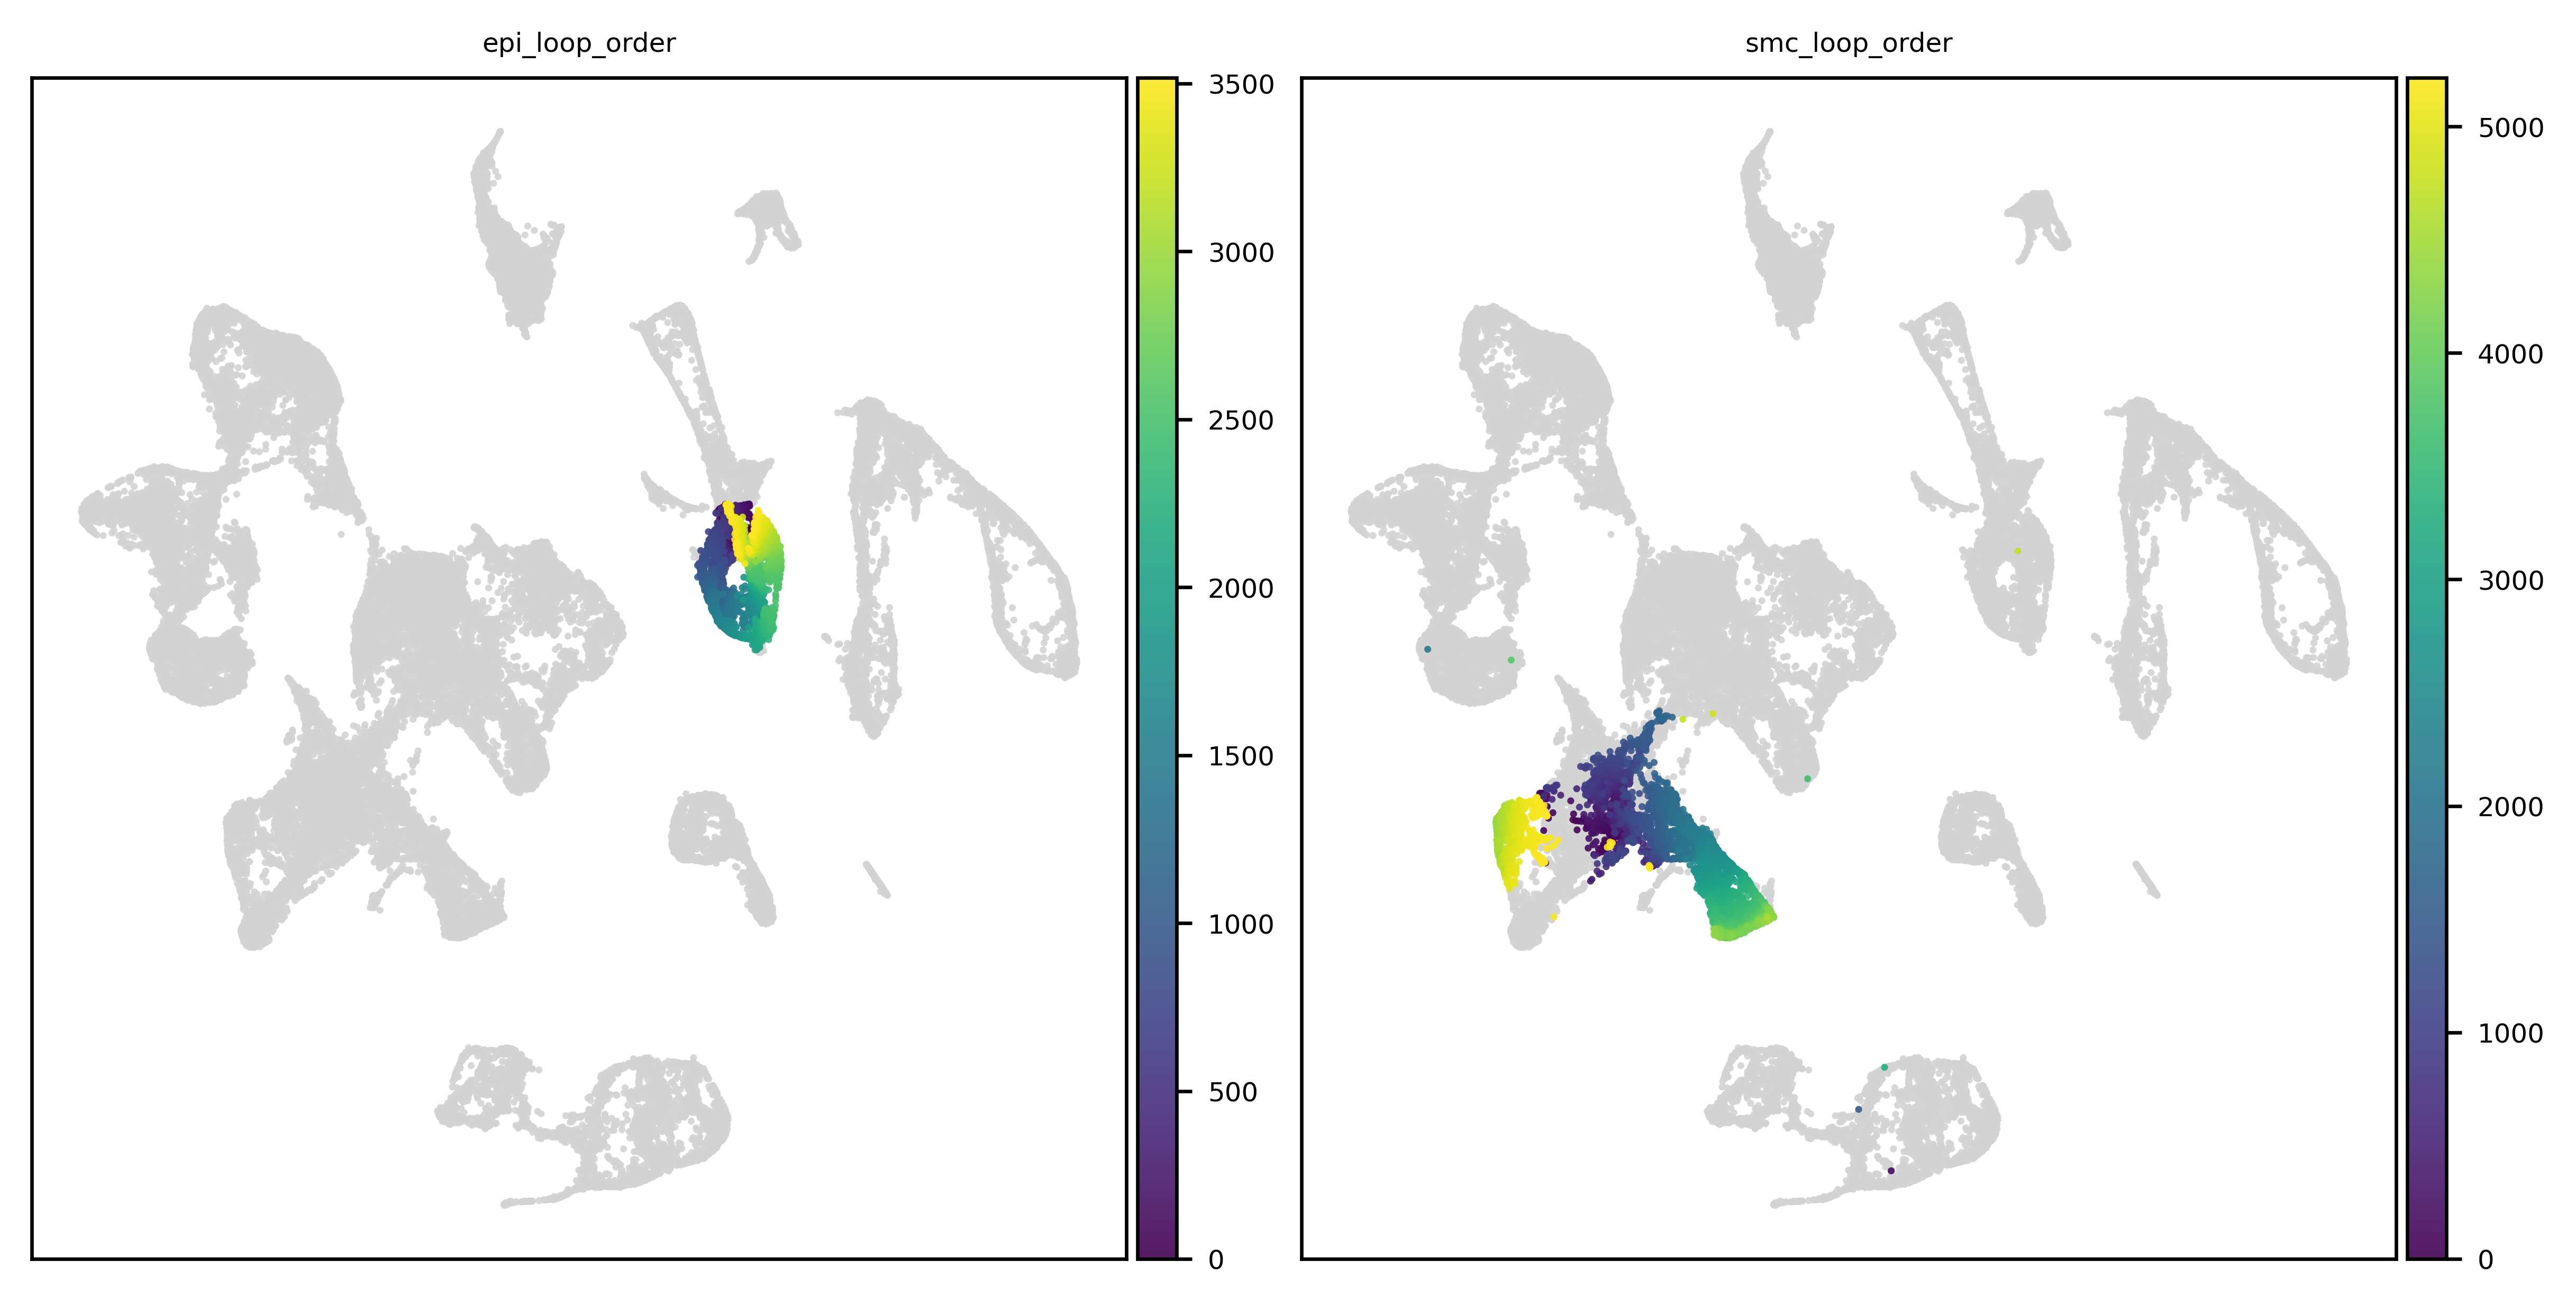

In [135]:
show_basis = 'concord_knn_UMAP'
show_cols = ['epi_loop_order', 'smc_loop_order']

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,4), dpi=600, ncols=2, font_size=6, point_size=10, legend_loc="on data",
    pal=pal,
    save_path=save_dir / f"{file_name}_{show_basis}_embedding.svg"
)